<a href="https://colab.research.google.com/github/RuthKassahun/Skin-Lesion-Classification/blob/main/Hu_Moments_.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# HU moments with Hair Removed 

## Import Libraries

In [101]:
import numpy as np 
import matplotlib.pyplot as plt
import glob
import cv2
import os
import seaborn as sns
import pandas as pd
from skimage.filters import sobel
from skimage.feature import greycomatrix, greycoprops
from skimage.measure import shannon_entropy
from sklearn.pipeline import Pipeline
from sklearn.svm import SVC, LinearSVC
from sklearn.ensemble import RandomForestClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.ensemble import AdaBoostClassifier
from sklearn.preprocessing import LabelEncoder, StandardScaler, MinMaxScaler
from sklearn import metrics
from pathlib import Path
import xgboost as xgb
import lightgbm as lgb
from PIL import Image, ImageOps
from sklearn.model_selection import GridSearchCV, StratifiedKFold
from sklearn.metrics import accuracy_score, auc, roc_curve, roc_auc_score, recall_score, confusion_matrix


## Load Data

In [102]:
print(os.listdir("/content/drive/MyDrive/train/sample_train"))
SIZE = 224

['other', 'nevus']


In [103]:
from zipfile import ZipFile
file_name = '/content/sample_check.zip'

with ZipFile(file_name, 'r') as zip:
  zip.extractall()
  print('Done')

Done


In [104]:
train_images = []
train_labels = [] 
hu_features = []
#for directory_path in glob.glob("cell_images/train/*"):
for directory_path in glob.glob("/content/drive/MyDrive/CAD_PROJECT/hair_removed/train/*"):
    label = directory_path.split("/")[-1]
    #print(label)
    for img_path in glob.glob(os.path.join(directory_path, "*.jpg")):
        #print(img_path)
        img = cv2.imread(img_path)[:, :, :3] #Reading color images
        img = cv2.resize(img, (SIZE, SIZE)) #Resize images
        train_images.append(img)
        train_labels.append(label)
        hu_feature = extract_hu_moments(img)
        hu_features.append(hu_feature)
        
train_images = np.array(train_images)
train_labels = np.array(train_labels)

In [105]:
train_images

array([[[[ 17,  18,  17],
         [ 16,  16,  11],
         [ 14,  15,  11],
         ...,
         [ 42,  36,  31],
         [ 43,  34,  30],
         [ 48,  41,  37]],

        [[ 48,  43,  40],
         [ 41,  37,  32],
         [ 24,  19,  16],
         ...,
         [ 38,  32,  27],
         [ 49,  40,  36],
         [ 50,  42,  38]],

        [[ 28,  28,  21],
         [ 21,  21,  15],
         [ 21,  20,  16],
         ...,
         [ 39,  33,  29],
         [ 52,  43,  39],
         [ 44,  38,  33]],

        ...,

        [[101,  89,  81],
         [193, 183, 168],
         [180, 176, 151],
         ...,
         [ 14,  12,  11],
         [ 17,  15,  14],
         [ 17,  15,  14]],

        [[135, 123, 113],
         [130, 118, 106],
         [120, 115,  90],
         ...,
         [ 16,  14,  13],
         [ 16,  14,  12],
         [ 17,  15,  14]],

        [[156, 145, 131],
         [129, 117, 106],
         [118, 109,  89],
         ...,
         [ 15,  13,  12],
        

In [106]:
print(train_labels)

['nevus' 'nevus' 'nevus' ... 'other' 'other' 'other']


In [107]:
test_images = []
test_labels = []
hu_features_test = []

#for directory_path in glob.glob("cell_images/test/*"): 
for directory_path in glob.glob("/content/drive/MyDrive/CAD_PROJECT/hair_removed/test/*"):
    test_label = directory_path.split("/")[-1]
    for img_path in glob.glob(os.path.join(directory_path, "*.jpg")):
        img = cv2.imread(img_path)[:, :, :3]
        img = cv2.resize(img, (SIZE, SIZE))
        test_images.append(img)
        test_labels.append(test_label)
        hu_feature_test = extract_hu_moments(img)
        hu_features_test.append(hu_feature_test)
        
        
test_images = np.array(test_images)
test_labels = np.array(test_labels)


## Label Encoding

In [108]:
from sklearn import preprocessing
le = preprocessing.LabelEncoder()
le.fit(test_labels)
test_labels_encoded = le.transform(test_labels)
le.fit(train_labels)
train_labels_encoded = le.transform(train_labels)

In [109]:
x_train, y_train, x_test, y_test = hu_features, train_labels_encoded, hu_features_test, test_labels_encoded


In [110]:
X_for_ML = x_train
X_test_ML = x_test


## SVM

In [111]:
pipe1 = Pipeline([
                 ("scale", StandardScaler()),
                 ("classifier", SVC(class_weight='balanced', probability=True, kernel= 'rbf', gamma=0.01, C=100)) #radial basis function kernel
                 ])

In [112]:
pipe1.fit(X_for_ML,train_labels_encoded)

Pipeline(steps=[('scale', StandardScaler()),
                ('classifier',
                 SVC(C=100, class_weight='balanced', gamma=0.01,
                     probability=True))])

Accuracy: 49.48%


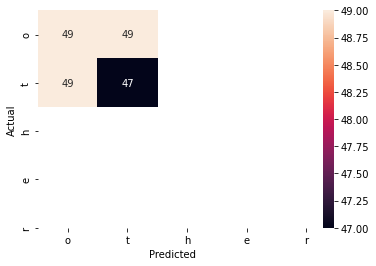

In [113]:
# Test set evaluation
prediction = pipe1.predict(x_test)
# Visualization
cmat = metrics.confusion_matrix(prediction,test_labels_encoded)
s = sns.heatmap(cmat,annot=True,xticklabels=label, yticklabels=label)
s.set(xlabel='Predicted', ylabel='Actual')
acc = cmat.trace() / cmat.sum()
print('Accuracy: {0:5.2f}%'.format(acc*100))

In [114]:
prediction_prob = pipe1.predict_proba(X_test_ML)
print("Area under curve (AUC): ", roc_auc_score(test_labels_encoded, prediction_prob[:,1]))

Area under curve (AUC):  0.4931972789115646


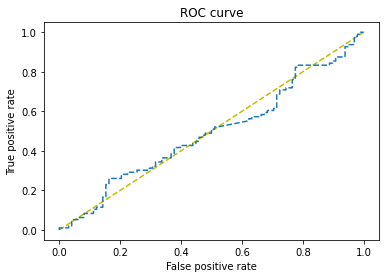

In [115]:
fpr, tpr, thresholds = roc_curve(test_labels_encoded, prediction_prob[:,1]) # outputs false positive rate, true positive rate, and corresponding thresholds.
plt.figure(1)
plt.plot([0,1],[0,1], 'y--')
plt.plot(fpr, tpr, linestyle = '--')
plt.xlabel('False positive rate')
plt.ylabel('True positive rate')
plt.title('ROC curve')
plt.show()

## Random Forest

In [116]:
pipe2 = Pipeline([
                 ("scale", StandardScaler()),
                 ("classifier", RandomForestClassifier(n_estimators = 100, random_state = 42))
                 ])

In [117]:
pipe2.fit(X_for_ML,train_labels_encoded)

Pipeline(steps=[('scale', StandardScaler()),
                ('classifier', RandomForestClassifier(random_state=42))])

Accuracy: 54.64%


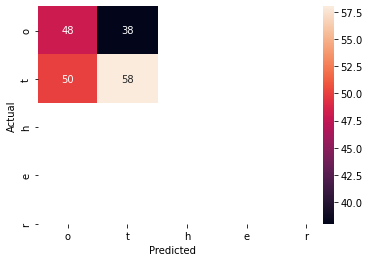

In [118]:
# Test set evaluation
prediction = pipe2.predict(X_test_ML)
# Visualization
cmat = metrics.confusion_matrix(prediction,test_labels_encoded)
s = sns.heatmap(cmat,annot=True,xticklabels=label, yticklabels=label)
s.set(xlabel='Predicted', ylabel='Actual')
acc = cmat.trace() / cmat.sum()
print('Accuracy: {0:5.2f}%'.format(acc*100))

In [119]:
prediction_prob = pipe2.predict_proba(X_test_ML)
print("Area under curve (AUC): ", roc_auc_score(test_labels_encoded, prediction_prob[:,1]))

Area under curve (AUC):  0.5504889455782312


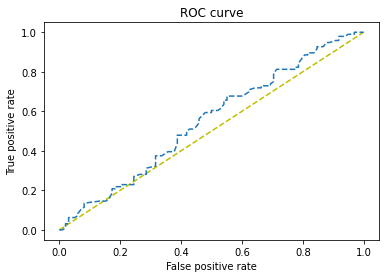

In [120]:
fpr, tpr, thresholds = roc_curve(test_labels_encoded, prediction_prob[:,1]) # outputs false positive rate, true positive rate, and corresponding thresholds.
plt.figure(1)
plt.plot([0,1],[0,1], 'y--')
plt.plot(fpr, tpr, linestyle = '--')
plt.xlabel('False positive rate')
plt.ylabel('True positive rate')
plt.title('ROC curve')
plt.show()

## KNN

In [121]:
pipe3 = Pipeline([
                 ("scale",StandardScaler()),
                 ("classifier", KNeighborsClassifier(n_neighbors=7))
                 ])

In [122]:
pipe3.fit(X_for_ML,train_labels_encoded)

Pipeline(steps=[('scale', StandardScaler()),
                ('classifier', KNeighborsClassifier(n_neighbors=7))])

In [123]:
prediction_prob = pipe3.predict_proba(X_test_ML)
print("Area under curve (AUC): ", roc_auc_score(test_labels_encoded, prediction_prob[:,1]))

Area under curve (AUC):  0.5491602891156462


Accuracy: 52.58%


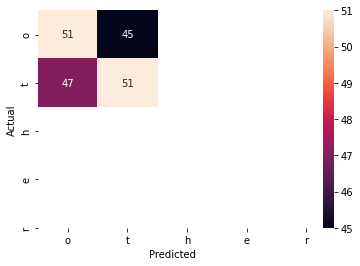

In [124]:
# Test set evaluation
prediction = pipe3.predict(X_test_ML)
# Visualization
cmat = metrics.confusion_matrix(prediction,test_labels_encoded)
s = sns.heatmap(cmat,annot=True,xticklabels=label, yticklabels=label)
s.set(xlabel='Predicted', ylabel='Actual')
acc = cmat.trace() / cmat.sum()
print('Accuracy: {0:5.2f}%'.format(acc*100))

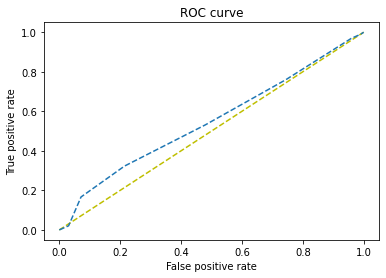

In [125]:
fpr, tpr, thresholds = roc_curve(test_labels_encoded, prediction_prob[:,1]) # outputs false positive rate, true positive rate, and corresponding thresholds.
plt.figure(1)
plt.plot([0,1],[0,1], 'y--')
plt.plot(fpr, tpr, linestyle = '--')
plt.xlabel('False positive rate')
plt.ylabel('True positive rate')
plt.title('ROC curve')
plt.show()

## AdaBoost

In [126]:
clf = AdaBoostClassifier(n_estimators=200, random_state=0)
clf.fit(X_for_ML,train_labels_encoded)

AdaBoostClassifier(n_estimators=200, random_state=0)

In [127]:
prediction_prob = clf.predict_proba(X_test_ML)
print("Area under curve (AUC): ", roc_auc_score(test_labels_encoded, prediction_prob[:,1]))

Area under curve (AUC):  0.5189200680272109


Accuracy: 50.00%


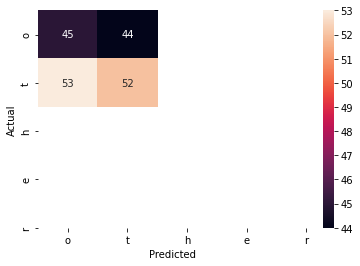

In [128]:
# Test set evaluation
prediction = clf.predict(X_test_ML)
# Visualization
cmat = confusion_matrix(prediction,test_labels_encoded)
s = sns.heatmap(cmat,annot=True,xticklabels=label, yticklabels=label)
s.set(xlabel='Predicted', ylabel='Actual')
acc = cmat.trace() / cmat.sum()
print('Accuracy: {0:5.2f}%'.format(acc*100))

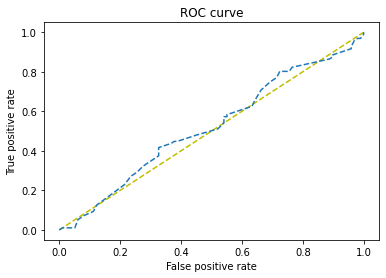

In [129]:
fpr, tpr, thresholds = roc_curve(test_labels_encoded, prediction_prob[:,1]) # outputs false positive rate, true positive rate, and corresponding thresholds.
plt.figure(1)
plt.plot([0,1],[0,1], 'y--')
plt.plot(fpr, tpr, linestyle = '--')
plt.xlabel('False positive rate')
plt.ylabel('True positive rate')
plt.title('ROC curve')
plt.show()

## XGB

In [130]:
mod1 = xgb.XGBClassifier(booster='dart',learning_rate=0.1)
train_arr = np.array(X_for_ML)
test_arr = np.array(X_test_ML)
mod1.fit(train_arr, train_labels_encoded)

XGBClassifier(booster='dart')

In [131]:
prediction = mod1.predict(test_arr)
print("Accuracy = ", accuracy_score(test_labels_encoded, prediction))

Accuracy =  0.5927835051546392


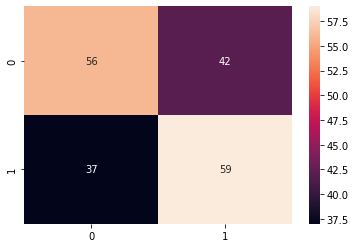

In [132]:
cm = confusion_matrix(test_labels_encoded, prediction)
sns.heatmap(cm, annot=True)

In [133]:
prediction_prob = mod1.predict_proba(test_arr)
print("Area under curve (AUC): ", roc_auc_score(test_labels_encoded, prediction_prob[:,1]))

Area under curve (AUC):  0.5787627551020409


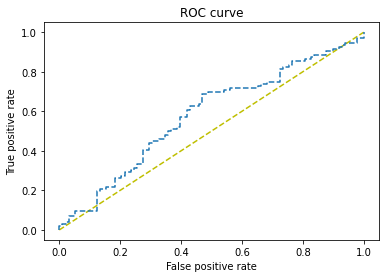

In [134]:
fpr, tpr, thresholds = roc_curve(test_labels_encoded, prediction_prob[:,1]) # outputs false positive rate, true positive rate, and corresponding thresholds.
plt.figure(1)
plt.plot([0,1],[0,1], 'y--')
plt.plot(fpr, tpr, linestyle = '--')
plt.xlabel('False positive rate')
plt.ylabel('True positive rate')
plt.title('ROC curve')
plt.show()

## LightGBM

In [135]:
scaler = StandardScaler()
train_scaled = scaler.fit_transform(X_for_ML)
test_scaled = scaler.transform(X_test_ML)
d_train = lgb.Dataset(train_scaled, label=train_labels_encoded)

In [136]:
lgbm_params = {'learning_rate':0.05, 'boosting_type':'gbdt', #Sometimes dart gives better accuracy. gbdt means gradient boosting.
              'objective':'binary',
              'metric':['auc', 'binary_logloss'],
              'num_leaves':100, # optimizing this avoids overfitting. 50 to 100
              'max_depth':10} #10 may be appropriate

In [137]:
clf = lgb.train(lgbm_params, d_train, 50) #50 iterations. Increase iterations for small learning rates. eg if learning grate = 0.005, we may need 500 iterations.
prediction=clf.predict(test_scaled)
#convert the probabilities into binary values 0/1 for classification
for i in range(0, test_scaled.shape[0]):
    if prediction[i]>=.5: # setting threshold to 0.5
       prediction[i]=1
    else:  
       prediction[i]=0

Accuracy with LGBM =  0.5463917525773195


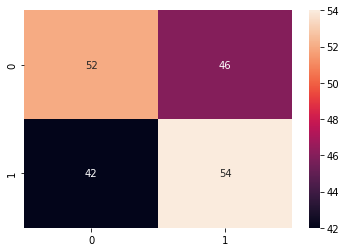

In [138]:
#Print accuracy
print ("Accuracy with LGBM = ", accuracy_score(test_labels_encoded, prediction))
#Confusion matrix
cm_lgbm = confusion_matrix(test_labels_encoded, prediction)
sns.heatmap(cm_lgbm, annot=True)

In [139]:
prediction_prob=clf.predict(test_scaled)
print("Area under curve (AUC): ", roc_auc_score(test_labels_encoded, prediction_prob))

Area under curve (AUC):  0.5317283163265306


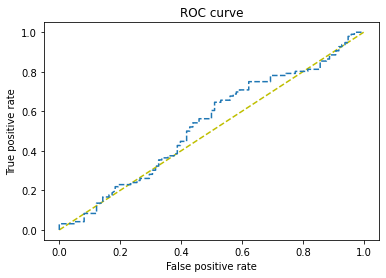

In [140]:
fpr, tpr, thresholds = roc_curve(test_labels_encoded, prediction_prob) # outputs false positive rate, true positive rate, and corresponding thresholds.
plt.figure(1)
plt.plot([0,1],[0,1], 'y--')
plt.plot(fpr, tpr, linestyle = '--')
plt.xlabel('False positive rate')
plt.ylabel('True positive rate')
plt.title('ROC curve')
plt.show()